In [1]:
import scipy.io as spio
import numpy as np

In [2]:
X = spio.loadmat(file_name='../data/bci/x.mat')

In [3]:
Y = spio.loadmat(file_name='../data/bci/y.mat')

In [4]:
X_train = X['Intensification_Data']
Y_train = Y['Intensification_SType'].mean(axis=1)

In [5]:
# HAR classification 
# Author: Burak Himmetoglu
# 8/15/2017

import pandas as pd

def standardize(train, test):
	""" Standardize data """

	# Standardize train and test
	X_train = (train - np.mean(train, axis=0)[None,:,:]) / np.std(train, axis=0)[None,:,:]
	X_test = (test - np.mean(test, axis=0)[None,:,:]) / np.std(test, axis=0)[None,:,:]

	return X_train, X_test

def one_hot(labels, n_class = 6):
	""" One-hot encoding """
	expansion = np.eye(n_class)
	y = expansion[:, labels-1].T
	assert y.shape[1] == n_class, "Wrong number of labels!"

	return y

def get_batches(X, y, batch_size ):
	""" Return a generator for batches """
	n_batches = len(X) // batch_size
	X, y = X[:n_batches*batch_size], y[:n_batches*batch_size]

	# Loop over batches and yield
	mb = []
	for b in range(0, len(X), batch_size):
# 		yield X[b:b+batch_size], y[b:b+batch_size]
		mb.append((X[b:b+batch_size], y[b:b+batch_size]))
	return mb

In [6]:
def normalize(X):
	""" Standardize data """

	# Standardize train and test
	X_norm = (X - np.mean(X, axis=0)[None,:,:]) / np.std(X, axis=0)[None,:,:]

	return X_norm

In [7]:
X_norm = normalize(X=X_train)

In [8]:
# Deviding the input data into train and validation
length = X_norm.shape[0]//10
X_train_norm = X_norm[: -length]
X_valid_norm = X_norm[-length:]

In [9]:
Y_train_norm = Y_train[ :-length]
Y_valid_norm = Y_train[-length: ]

In [10]:
Y_valid_norm = np.array(Y_valid_norm, dtype=int)
Y_train_norm = np.array(Y_train_norm, dtype=int)

In [11]:
Y_train_onehot = one_hot(labels=Y_train_norm, n_class=2)
Y_valid_onehot = one_hot(labels=Y_valid_norm, n_class=2)

### Hyperparameters

In [12]:
# Input: X_(5832, 192, 64): (n_trials, seq_len, n_channels), batch_size== n_trials
batch_size = X_train_norm.shape[0]// 100 # Batch size: number of trials
seq_len = X_train_norm.shape[1]          # Number of steps: each trial length
n_channels = X_train_norm.shape[2] # number of channels in each trial

# FC layer: Shallow RNN
lstm_size = 3 *  n_channels # 3 times the amount of channels
lstm_layers = 1        # Number of layers

# Output: Y_(5832, 2): (n_trails, n_classes)
n_classes = Y_train_onehot.shape[1]

# Tweekable parameters
learning_rate = 0.001 #1e-3
epochs = 10
keep_prob = 0.9

# GPUs availability or CPU

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


/Users/arasdar/anaconda3/envs/arasdar-DL-env/lib/python3.5/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


In [14]:
graph = tf.Graph()

# Construct placeholders
with graph.as_default():
    inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs_')
    labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels_')
    keep_prob_ = tf.placeholder(tf.float32, name = 'keep_prob_')
    learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate_')

# Convolutional Layers

Note:  activation function, batch normalization, weight initialization, and dropout

In [15]:
with graph.as_default():
    # (batch, 128, 9) --> (batch, 64, 18)
    conv1 = tf.layers.conv1d(inputs=inputs_, filters=18, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_1 = tf.layers.max_pooling1d(inputs=conv1, pool_size=2, strides=2, padding='same')
    
    # (batch, 64, 18) --> (batch, 32, 36)
    conv2 = tf.layers.conv1d(inputs=max_pool_1, filters=36, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_2 = tf.layers.max_pooling1d(inputs=conv2, pool_size=2, strides=2, padding='same')
    
    # (batch, 32, 36) --> (batch, 16, 72)
    conv3 = tf.layers.conv1d(inputs=max_pool_2, filters=72, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_3 = tf.layers.max_pooling1d(inputs=conv3, pool_size=2, strides=2, padding='same')
    
    # (batch, 16, 72) --> (batch, 8, 144)
    conv4 = tf.layers.conv1d(inputs=max_pool_3, filters=144, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_4 = tf.layers.max_pooling1d(inputs=conv4, pool_size=2, strides=2, padding='same')

# Now, pass to LSTM cells

In [16]:
# with graph.as_default():
#     # Construct the LSTM inputs and LSTM cells
#     # reshape (batch, seq_len, channels) into (seq_len, batch, channels), X_(6480, 192, 64)
#     lstm_in = tf.transpose(max_pool_4, [1,0,2]) 
#     lstm_in = tf.reshape(lstm_in, [-1, n_channels]) # Now (seq_len*N, n_channels)
    
#     # To cells
#     lstm_in = tf.layers.dense(lstm_in, lstm_size, activation=None) # or tf.nn.relu, tf.nn.sigmoid, tf.nn.tanh?
    
#     # Open up the tensor into a list of seq_len pieces
#     lstm_in = tf.split(lstm_in, seq_len, 0)
    
#     # Add LSTM layers
#     lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)
#     dropout = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob_)
#     cell = tf.contrib.rnn.MultiRNNCell([dropout] * lstm_layers)
#     initial_state = cell.zero_state(batch_size, tf.float32)

In [ ]:
with graph.as_default():
    # Construct the LSTM inputs and LSTM cells
    # reshape (batch, seq_len, channels) into (seq_len, batch, channels), X_(6480, 192, 64)
    lstm_in = tf.transpose(max_pool_4, [1,0,2]) 
    lstm_in = tf.reshape(lstm_in, [-1, n_channels]) # Now (seq_len*N, n_channels)
    
    # To cells
    lstm_in = tf.layers.dense(lstm_in, lstm_size, activation=None) # or tf.nn.relu, tf.nn.sigmoid, tf.nn.tanh?
    
    # Open up the tensor into a list of seq_len pieces
    lstm_in = tf.split(lstm_in, seq_len, 0)
    
    # Add LSTM layers
    lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)
    dropout = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob_)
    cell = tf.contrib.rnn.MultiRNNCell([dropout]) # lstm_layers = 1
    initial_state = cell.zero_state(batch_size, tf.float32)

# FC layer: 
Now, flatten and pass to the classifier

In [23]:
with graph.as_default():
    #     # Flatten and add dropout
    #     #     print(max_pool_4.shape, *max_pool_4.shape) # (?, 12, 144)
    #     flat = tf.reshape(max_pool_4, (-1, 12*144))
    #     flat = tf.nn.dropout(x=flat, keep_prob=keep_prob_)
    # LSTM output
    outputs, final_state = tf.contrib.rnn.static_rnn(cell, lstm_in, dtype=tf.float32, 
                                                     initial_state = initial_state)
    
#     #     # Predictions
#     #     logits = tf.layers.dense(inputs=flat, units=n_classes)
#     # We only need the last output tensor to pass into a classifier
#     logits = tf.layers.dense(inputs=outputs[-1], units=n_classes, name='logits')
    
#     # Cost function and optimizer
#     cost = tf.reduce_mean(input_tensor=tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_))
#     optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate_).minimize(cost)
    
#     # Accuracy
#     correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
#     accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

ValueError: Variable rnn/multi_rnn_cell/cell_0/basic_lstm_cell/weights already exists, disallowed. Did you mean to set reuse=True in VarScope? Originally defined at:

  File "/Users/arasdar/anaconda3/envs/arasdar-DL-env/lib/python3.5/site-packages/tensorflow/contrib/rnn/python/ops/core_rnn_cell_impl.py", line 747, in _linear
    "weights", [total_arg_size, output_size], dtype=dtype)
  File "/Users/arasdar/anaconda3/envs/arasdar-DL-env/lib/python3.5/site-packages/tensorflow/contrib/rnn/python/ops/core_rnn_cell_impl.py", line 179, in __call__
    concat = _linear([inputs, h], 4 * self._num_units, True, scope=scope)
  File "/Users/arasdar/anaconda3/envs/arasdar-DL-env/lib/python3.5/site-packages/tensorflow/contrib/rnn/python/ops/core_rnn_cell_impl.py", line 524, in __call__
    output, new_state = self._cell(inputs, state, scope)


### Train the network

In [27]:
import os

if (os.path.exists('checkpoints-cnn-rnn') == False):
    !mkdir checkpoints-cnn-rnn

In [28]:
#  Testing get_batch()
XY_train = get_batches(X_train_norm, Y_train_onehot, batch_size)
len(XY_train)
X, Y = XY_train[0]

In [29]:
valid_acc_list = []
valid_loss_list = []

train_acc_list = []
train_loss_list = []

with graph.as_default():
    saver = tf.train.Saver()

# train and valid minibatches
XY_train = get_batches(X_train_norm, Y_train_onehot, batch_size)

with tf.Session(graph=graph) as sess:
    
    # Init session variables
    sess.run(tf.global_variables_initializer())
   
    # Loop over epochs: full batch/ dataset
    for epoch in range(epochs):
        
        # Initialize 
        state = sess.run(initial_state)

        # Loop over minibatches
        for idx in range(len(XY_train)):
            
            # Training for minibatches of training set
            X, Y = XY_train[idx]
            feed_dict = {inputs_:X , labels_:Y, keep_prob_:keep_prob, initial_state:state, 
                         learning_rate_:learning_rate}
            train_loss, _ , state, train_acc = sess.run([cost, optimizer, final_state, accuracy], 
                                                 feed_dict = feed_dict)
            train_acc_list.append(train_acc)
            train_loss_list.append(train_loss)
                                        
        # Validation for all validation set
        state = sess.run(cell.zero_state(batch_size, tf.float32))
        X, Y = X_valid_norm, Y_valid_onehot
        feed_dict = {inputs_:X , labels_:Y, keep_prob_:1.0, initial_state:state}
        valid_loss, valid_acc = sess.run([cost, accuracy], feed_dict = feed_dict)
        valid_acc_list.append(valid_acc)
        valid_loss_list.append(valid_loss)
                
        # Print info in each epoch/ iteration  OR full batch
        print("Epoch: {}/{}".format(epoch+1, epochs),
              "Train loss: {:6f}".format(train_loss),
              "Train acc: {:.6f}".format(train_acc),
              "Valid loss: {:6f}".format(valid_loss),
              "Valid acc: {:.6f}".format(valid_acc))
    
    # At the end of all epochs
    saver.save(sess,"checkpoints-cnn-rnn/bci.ckpt")

InvalidArgumentError: Number of ways to split should evenly divide the split dimension, but got split_dim 0 (size = 1566) and num_split 192
	 [[Node: split = Split[T=DT_FLOAT, num_split=192, _device="/job:localhost/replica:0/task:0/cpu:0"](split/split_dim, dense/BiasAdd)]]

Caused by op 'split', defined at:
  File "/Users/arasdar/anaconda3/envs/arasdar-DL-env/lib/python3.5/runpy.py", line 170, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/arasdar/anaconda3/envs/arasdar-DL-env/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/arasdar/anaconda3/envs/arasdar-DL-env/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/arasdar/anaconda3/envs/arasdar-DL-env/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/arasdar/anaconda3/envs/arasdar-DL-env/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/Users/arasdar/anaconda3/envs/arasdar-DL-env/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Users/arasdar/anaconda3/envs/arasdar-DL-env/lib/python3.5/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/Users/arasdar/anaconda3/envs/arasdar-DL-env/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/arasdar/anaconda3/envs/arasdar-DL-env/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/arasdar/anaconda3/envs/arasdar-DL-env/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/arasdar/anaconda3/envs/arasdar-DL-env/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/arasdar/anaconda3/envs/arasdar-DL-env/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/arasdar/anaconda3/envs/arasdar-DL-env/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/arasdar/anaconda3/envs/arasdar-DL-env/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/arasdar/anaconda3/envs/arasdar-DL-env/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/arasdar/anaconda3/envs/arasdar-DL-env/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/arasdar/anaconda3/envs/arasdar-DL-env/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/arasdar/anaconda3/envs/arasdar-DL-env/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/arasdar/anaconda3/envs/arasdar-DL-env/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/arasdar/anaconda3/envs/arasdar-DL-env/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-25-ac8713229ef7>", line 11, in <module>
    lstm_in = tf.split(lstm_in, seq_len, 0)
  File "/Users/arasdar/anaconda3/envs/arasdar-DL-env/lib/python3.5/site-packages/tensorflow/python/ops/array_ops.py", line 1216, in split
    split_dim=axis, num_split=num_or_size_splits, value=value, name=name)
  File "/Users/arasdar/anaconda3/envs/arasdar-DL-env/lib/python3.5/site-packages/tensorflow/python/ops/gen_array_ops.py", line 3426, in _split
    num_split=num_split, name=name)
  File "/Users/arasdar/anaconda3/envs/arasdar-DL-env/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "/Users/arasdar/anaconda3/envs/arasdar-DL-env/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2395, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Users/arasdar/anaconda3/envs/arasdar-DL-env/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1264, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): Number of ways to split should evenly divide the split dimension, but got split_dim 0 (size = 1566) and num_split 192
	 [[Node: split = Split[T=DT_FLOAT, num_split=192, _device="/job:localhost/replica:0/task:0/cpu:0"](split/split_dim, dense/BiasAdd)]]


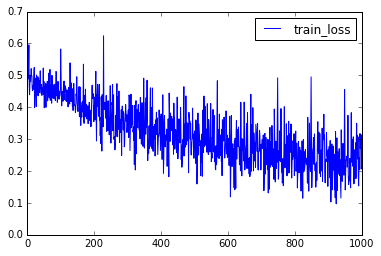

In [46]:
import matplotlib.pyplot as mplot

mplot.plot(train_loss_list, label='train_loss')
# mplot.plot(valid_loss_list, label='valid_loss')
mplot.legend()
mplot.show()

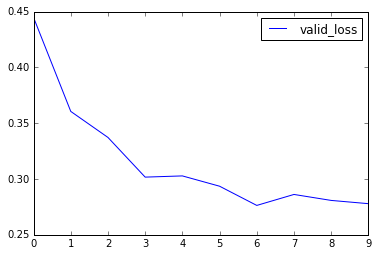

In [47]:
# import matplotlib.pyplot as mplot

# mplot.plot(train_loss_list, label='train_loss')
mplot.plot(valid_loss_list, label='valid_loss')
mplot.legend()
mplot.show()

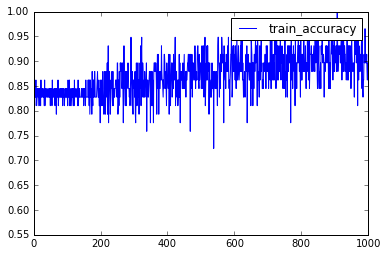

In [49]:
mplot.plot(train_acc_list, label='train_accuracy')
mplot.legend()
mplot.show()

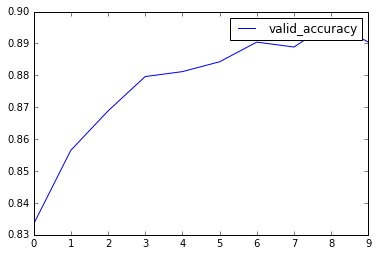

In [50]:
mplot.plot(valid_acc_list, label='valid_accuracy')
mplot.legend()
mplot.show()